# Length correction of AlpacaEval

This notebook is about trying to correct for the length bias in AlpacaEval. 

In [1]:
cd ..

/Users/yanndubois/Desktop/GitHub/alpaca_eval


In [2]:
from dotenv import load_dotenv
load_dotenv(".env")

True

## Desiderata?

Here are the desired properties that we would like for our length-corrected win-rate.

Here are the things that I think we should be considering when deciding
1. **(D1) Have high correlation with humans** ultimately the most important property for AlpacaEval is that it's highly correlated with humans. Arguably this is a property that we already have, so we should just make sure that the correlation of the length-corrected win-rate is at least as high, and ideally higher than the current correlation. Note that we have high-correlations with human despite the length bias because (1) humans are also length-biased; and (2) we have validated our auto-annotators compared to humans only in standard/realistic scenario rather than in extreme/"worst-case" ones. This brings us to D2.
2. **(D2) Low length gameability** one major issue with a bias metric is that adversarial players may take advantage of it, i.e., game the metric. This might not be seen when looking at standard correlation with humans because we rarely test gamed systems. Given that correlation with humans is already very high (D1), we see (D2) as the major new property that we are trying to achieve. We would thus ideally want gamed systems (e.g. by changing the system prompt to be verbose) to not change too much. Note that humans might not actually have such property, so we are asking more from our auto-annotators than humans. 
This is nevertheless very important for a leaderboard like AlpacaEval, because people usually think about it as an evalaution of a model rather than a system (model+prompt). We thus want to avoid having large prompt gameability so that it behaves closer to what people have in mind. 
3. **(D3) Similar length bias as humans**: human are typically length biased, the goal is thus not to be length-invariant but to match human biases. 
4. **(D4) Simplicity**: the model length correction should be simple enough for people to understand what is happening and what are limitations of the length corrections. Let's not hide the limitations (and potential gameability) behind complexity.
5. **(D5) Similar interpretation as win-rate**: given that we'll use for the default AE metric, we would like the interpretation of the result to be as similar as  possible as the non-bias corrected ones given that people are used to those. I.e. preference for having 50% for the baseline, the range being between 0-100, ...
6. **(D6) General procedure**: although length-bias is the biggest issue, AlpacaEval has other biases (e.g. bias towards lists, bias towards outputs similar to those from the autoannotator, ...). We thus like a general procedure to deal with biases so that we can reuse it when needed, and others can use simialr procedures for their benchmark.
7. **(D7) Robustness**: we want to avoid as much as possible having settings in which the length-corrected metric can be gamed in a different way. E.g. by generating extremely short answers.
8. **(D8) Independence between models**: as much as possible we would like our correction to not depend on the outputs / values / ranking of other models. In particular, we want the length-corrected metric to not have to be updated when future models (e.g. that are very long) are developed.

In addition to the aforementioned desired properties, we have a hard constraint that there should be **no reevaluation needed**. I.e., the new metric should be a function of what we currently have to ensure that we can port the leaderboard.

Now let's check how to decide whether a method is better or worse, i.e., what metrics to consider for the rest of the notebook.

## Metrics?

Stratified arena correlation per length. Per output.

Here are the metrics I think we should be considering, one for each of the three desiderata.

- **(D1) High Spearman correlation with Chatbot Arena Leaderboard.** This is the most important, and Chatbot arena as source of human truth given that it's the only large scale and in-the-wild chat leaderboard based on human data. The question then becomes which correlations. Given that ELO and win rate are very different metrics (e.g. one is bounded and not the other) there's no reason to hope that linear correlation holds, so we shouldn't use Pearson. More importantly, we only care about relative values with a benchmark like AlpacaEval (the usecase being model selection) so non-parametric correlation is better suited. Note that the choice of Spearman vs Kendall doesn't matter much here, we will use Spearman because it's on "the same scale" as Pearson correlation which people are more used to (e.g. Kendall is much smaller which always surprises people because they are not used to interpreting it). Also note that when using non-parametric correlations it's extremely important to fix the number of points you are comparing, otherwise more points always looks better. 

  
- **(D2) Small relative variance when prompting for verbosity/conciseness.** One heuristic to avoid gameability is to ensure that the win-rate for a model is close to the win-rate of the same model prompted for verbosity. To test that we will use a few models and prompt them (1) normally, (2) to "give as much detail as possible", (3) to "be as concise as possible while still providing all the necessary information to answer the question". Then we will look at the variance between those three, which ideally shouldn't be too large. We will use GPT4-turbo, Claude 2, GPT3-turbo, GPT4, Mixtral. In particular, we will consider the relative standard deviation. Standard deviation, simply because it's easier to interpret. Relative in the sense that we (1) normalize by the non-gamed win rate, and (2) we normalize by the standard deviation of different models, i.e., squishing the range of the metric shouldn't solve the gameability issue. Note that ideally, we would actually estimate the gameability of humans and be able to compare to that. Unfortunately LMSys doesn't evaluate the same model with different prompts. @todo: ask them.


- **(D3) Same Spearman correlation AE-Length as Arena-Length.** To track the length bias of humans we can see how correlated the Arena leaderboard is with a leaderboard that simply ranks outputs by their lengths. Again we use Spearman correlations.


- **(D1) Have high correlation with humans** 
- **(D2) Low length gameability** 
- **(D3) Similar length bias as humans**
- **(D4) Simplicity**
- **(D5) Similar interpretation as win-rate**
- **(D6) General procedure**
- **(D7) Robustness**
- **(D8) Independence between models**

## Setting up 

In [65]:
%matplotlib inline

from alpaca_eval import utils, metrics, annotators, constants, analyze, plotting, main
import pandas as pd
from IPython.display import display
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import logging
import pickle
from pathlib import Path
from patsy import dmatrix
from sklearn.linear_model import LogisticRegressionCV, LinearRegression, RidgeCV, LogisticRegression
from sklearn.model_selection import GroupKFold
import sklearn
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from patsy import build_design_matrices
sklearn.set_config(enable_metadata_routing=True)

BASELINE = "gpt4_1106_preview"

In [4]:
lb = pd.read_csv("src/alpaca_eval/leaderboards/data_AlpacaEval_2/weighted_alpaca_eval_gpt4_turbo_leaderboard.csv", index_col=0)

def make_lb_arena(lb):
    lb_arena = lb.loc[list(constants.CHATBOT_ARENA_LEADERBOARD.keys()),:]
    lb_arena["ELO"] = constants.CHATBOT_ARENA_LEADERBOARD.values()
    return lb_arena

lb_arena = make_lb_arena(lb)
print(f"We are comparing to {len(lb_arena)} Arena models")

We are comparing to 33 Arena models


In [5]:
game_process_v = lambda s : s.replace("_verbose","")
game_process_c = lambda s : s.replace("_concise","")
gamed_models = [i for i in lb.index
               if (i + "_verbose") in lb.index and (i + "_concise") in lb.index]
diff_models = [i for i in lb.index
               if "_verbose" not in i and i + "_concise" not in i]
lb["gamed_verbose_only"] = [game_process_v(i) if game_process_v(i) in gamed_models else None for i in lb.index]
lb["gamed_concise_only"] = [game_process_c(i) if game_process_c(i) in gamed_models else None for i in lb.index]

Here are the models that we gamed (i.e. prompted for verbosity/conciseness)

In [6]:
gamed_models

['gpt4_1106_preview',
 'Mixtral-8x7B-Instruct-v0.1',
 'gpt4_0613',
 'claude-2.1',
 'gpt-3.5-turbo-1106',
 'alpaca-7b']

In [7]:

def report(lb, metric, is_detailed=False, n_toshow=10, is_return_metrics=False):
    lb_arena = make_lb_arena(lb)

    if not is_return_metrics:
        print(f"# Report for **{metric}**")

        print()
        print("## Gameability (lower is better)")

    df_gamed_v = lb.groupby("gamed_verbose_only")[["avg_length", metric]].agg(["mean","std"]) 
    df_gamed_c = lb.groupby("gamed_concise_only")[["avg_length", metric]].agg(["mean","std"]) 
    # relative in the sense that models with larger metric shouldn't be considered as having larger vairance
    df_gamed_v[(metric, 'rel_std')] = df_gamed_v[metric]["std"] /  df_gamed_v[metric]["mean"]
    df_gamed_c[(metric, 'rel_std')] = df_gamed_c[metric]["std"] /  df_gamed_c[metric]["mean"] 
    # renormalize to avoid removing gameability by shrinking the scale of the metric
    winrate_std_across_models = lb[lb.index.isin(diff_models)]["win_rate"].std()
    metric_std_across_models = lb[lb.index.isin(diff_models)][metric].std()
    metric_weight = winrate_std_across_models / metric_std_across_models 
    
    if is_detailed:
        print(f"metric_weight: {metric_weight:.3f}")
        display(df_gamed_v)
        display(df_gamed_c)

    verbosity_gameability = df_gamed_v[metric]['rel_std'].mean() * metric_weight * 100
    conciseness_gameability = df_gamed_c[metric]['rel_std'].mean() * metric_weight * 100
    
    if not is_return_metrics:
        print(f"Verbosity gameability (relative std metric): {verbosity_gameability:.1f}%")
        print(f"Conciseness gameability (relative std metric): {conciseness_gameability:.1f}%")

        print()
        print("## Correlation with Arena (higher is better)")

    corr_arena = print_correlations(lb_arena[metric], lb_arena["ELO"], is_return_metrics=is_return_metrics)

    if not is_return_metrics:
        print()
        arena_corr = print_correlations(lb_arena["ELO"],
                                       lb_arena["avg_length"],
                                        "Arena vs Length", 
                                        is_return_metrics=True)
        print(f"## Correlation with length (closer to spearman={arena_corr['spearman']:.2f}, kendall={arena_corr['kendall']:.2f} is better)")
    
    corr_len = print_correlations(lb_arena[metric], lb_arena["avg_length"], is_return_metrics=is_return_metrics)

    if not is_return_metrics:
        print()
        print(f"## Top {n_toshow} models")
    
        display(lb[metric].sort_values(ascending=False)[:n_toshow])
    
        print()
        print(f"## Bottom {n_toshow} models")
    
        display(lb[metric].sort_values(ascending=False)[-n_toshow:])

    if is_return_metrics:
        return dict(verbosity_gameability=verbosity_gameability, 
                    conciseness_gameability=conciseness_gameability,
                   corr_arena=corr_arena["spearman"],
                    corr_len=corr_len["spearman"])


def show_new_lb(lb, column):

    delta_lb = lb.copy()
    delta_lb["new_win_rate"] = delta_lb[column]
    delta_lb = delta_lb[["win_rate", "new_win_rate"]]
    delta_lb["delta_win_rate"] = delta_lb["new_win_rate"] - delta_lb["win_rate"] 
    
    rank_win_rate = delta_lb["win_rate"].sort_values(ascending=False).to_frame()
    rank_win_rate["rank"] = range(len(rank_win_rate))
    delta_lb["rank_win_rate"] = rank_win_rate.loc[delta_lb.index, "rank"]
    
    rank_new_win_rate = delta_lb["new_win_rate"].sort_values(ascending=False).to_frame()
    rank_new_win_rate["rank"] = range(len(rank_new_win_rate))
    delta_lb["rank_new_win_rate"] = rank_new_win_rate.loc[delta_lb.index, "rank"]
    
    delta_lb["delta_rank"] = delta_lb["rank_win_rate"] - delta_lb["rank_new_win_rate"]

    styled_delta_lb = delta_lb.style.background_gradient(subset=["delta_win_rate"], cmap='RdBu_r', low=0.5,  high=0.5
                                                        ).background_gradient(subset=["delta_rank"], cmap='RdBu_r', low=0.5,  high=0.5)
    return styled_delta_lb

In [8]:

def print_correlations(arr1, arr2, txt="", is_return_metrics=False):
    if isinstance(arr1, pd.DataFrame):
        arr1 = list(arr1.index)
    if isinstance(arr2, pd.DataFrame):
        arr2 = list(arr2.index)
    s = scipy.stats.spearmanr(arr1, arr2).statistic
    t = scipy.stats.kendalltau(arr1, arr2).statistic
    
    if is_return_metrics:
        return dict(spearman=s, kendall=t)
    else:
        if txt != "":
            txt = txt + "\n"
        print(f"{txt}Spearman Corr: {s:.3f}\nKendall Corr: {t:.3f}")

Here are the correlations between Arena and length that we should try to be close to. 

In [9]:
print_correlations(lb_arena["ELO"],
                   lb_arena["avg_length"],
                  "Arena vs Length")

Arena vs Length
Spearman Corr: 0.236
Kendall Corr: 0.163


## Raw win rate

- **What**: compute the expected number of times that the model is better than the baseline. This is the default in AE.
- **Benefits**: simple
- **Downside**: length bias

In [10]:
report(lb, "win_rate", is_detailed=False)

# Report for **win_rate**

## Gameability (lower is better)
Verbosity gameability (relative std metric): 21.3%
Conciseness gameability (relative std metric): 29.8%

## Correlation with Arena (higher is better)
Spearman Corr: 0.921
Kendall Corr: 0.788

## Correlation with length (closer to spearman=0.24, kendall=0.16 is better)
Spearman Corr: 0.467
Kendall Corr: 0.324

## Top 10 models


gpt4_1106_preview_verbose                64.303601
gpt4_1106_preview                        50.000000
Snorkel-Mistral-PairRM-DPO-best-of-16    34.860133
pairrm-Yi-34B-Chat                       31.241283
Snorkel-Mistral-PairRM-DPO               30.220053
Yi-34B-Chat                              29.659947
Qwen1.5-72B-Chat                         26.498283
Mixtral-8x7B-Instruct-v0.1_verbose       24.614063
claude-2.1_verbose                       24.354071
gpt4                                     23.576789
Name: win_rate, dtype: float64


## Bottom 10 models


guanaco-7b              2.880002
chatglm2-6b             2.762185
text_davinci_001        2.757166
alpaca-7b               2.591451
pythia-12b-mix-sft      2.578090
phi-2                   2.344452
falcon-7b-instruct      2.146618
baichuan-13b-chat       1.992146
alpaca-7b_concise       1.988703
oasst-sft-pythia-12b    1.790114
Name: win_rate, dtype: float64

We see that:
- gameability due to asking for details is high
- correlation with Arena is relatively high
- correlation with length is >2x than Arena

# Proposed metrics to consider

First, let's compute some values---based on annotations---that will be useful for all the proposed metrics. Note throughout the rest that 1 -> baseline, and 2 -> model being evaluated.

In [10]:
def load_annotations(lb):
    """Load annotations from models in lb and add some statistics that may be useful."""
    annotations = {}
        
    for i in lb.index:
        # load actual annotations to see if it was longer or not 
        df_annotations = pd.read_json(f"results/{i}/weighted_alpaca_eval_gpt4_turbo/annotations.json")
        df_annotations["len_1"] = df_annotations["output_1"].str.len()  
        df_annotations["len_2"] = df_annotations["output_2"].str.len()  
        df_annotations["is_longer2"] = df_annotations["len_1"] < df_annotations["len_2"]     
        df_annotations["is_longer1"] = df_annotations["len_2"] < df_annotations["len_1"] 
        df_annotations["is_same_length"] = df_annotations["len_2"] == df_annotations["len_1"] 
        df_annotations["model"] = i
        annotations[i] = df_annotations.reset_index().drop(columns=["raw_completion", "output_2", "output_1", "instruction"]) # drop all the long stuff that is not needed

    df_annotations = pd.concat(annotations, ignore_index=True).query("preference >= 0")
    df_annotations["preference"] = (df_annotations["preference"].astype(float).replace({0.0: 1.5}) - 1) # easier to work with
    return df_annotations

In [11]:
def plot_metrics_vs_param(get_new_win_rate, parameters, metric_name, **kwargs):
    verbosity_gameability = []
    conciseness_gameability = []
    corr_arena = []
    corr_len = []
    
    for parameter in parameters:
        lb_longer[metric_name] = get_new_win_rate(lb_longer, parameter, **kwargs)
        metrics = report(lb_longer, metric_name, is_detailed=False, is_return_metrics=True)
        verbosity_gameability.append(metrics["verbosity_gameability"])
        conciseness_gameability.append(metrics["conciseness_gameability"])
        corr_len.append(metrics["corr_len"])
        corr_arena.append(metrics["corr_arena"])

        if metrics["corr_arena"] >= pd.Series(corr_arena).max():
            lb_longer[metric_name+"_best"] = lb_longer[metric_name]

    metrics_w = pd.DataFrame(dict(parameter=parameters, verbosity_gameability=verbosity_gameability, conciseness_gameability=conciseness_gameability, corr_arena=corr_arena, corr_len=corr_len))
    to_plot = metrics_w.melt(value_name="value", var_name="metric", value_vars=metrics.keys(), id_vars="parameter")
    g= sns.relplot(to_plot, x='parameter', 
                       y='value', col='metric', kind="line", 
                        facet_kws=dict(sharey=False))
    return g

In [12]:
all_df_annotations = load_annotations(lb)
all_df_annotations = all_df_annotations.query("len_2 != 0")

## Balanced win rate

Background: oen common way to control for a covariate that you don't want to take into account is by stratification. Here we will stratify the data by "longer than baseline" and "shorter than baseline".

- **What**: compute the expected number of times that the model is better than the baseline when the outputs of the model are (1) longer, and (2) shorter than the baseline. Then take the average between both settings.
- **Benefits**:
    - **(D1-D3) metrics**: much better in all metrics than raw win-rate, although seems to overcorrect length bias.
    - **(D4) simplicity**: simple to understand
    - **(D5) interpretability**: simple to interpret & similar interpretation as win-rate
    - **(D8) independence**: can apply the correction independently of each model.
- **Downside**:
    - there might be a cofounder between the complexity of the task and which outputs are longer.
    - **(D6) generality**: although the  procedure. Hard to apply for other biases, given that it would split the space exponentially.
    - **(D7) robustness**: not robust for cases where there are very few answer that are either short or longer than the baseline.  High variance / gameable if models have only a few outputs in one of the two categories. E.g. everything is shorter than baseline => should not allow evla of such model.
 
Overall I like this simple (to compute & to interpret) controlled-length. I think it's better in most respect than the raw win rate. My major worry is that it makes the metric really bad in the case of models that are nearly always shorter or longer than the baseline.

In [13]:
def add_metrics_for_longer_balancing(lb, all_df_annotations):
    """Computes the mean and variance fo win rate grouped by whether the model is longer/shorter than the baseline"""
    lb = lb.copy()
    keys = ["mean_1longer", "mean_2longer", "var_1longer", "var_2longer", "count_2longer", "count_2longer",
           
           ]
    annotations = {}
    for k in keys:
        lb[k] = None
        
    for i in lb.index:
        # load actual annotations to see if it was longer or not 
        df_annotations = all_df_annotations[all_df_annotations.model == i]

        lb.loc[i,"mean"] = df_annotations["preference"].mean()
        groupby_islonger1 = df_annotations.groupby("is_longer1")["preference"].agg(["mean", "var"])
        groupby_islonger2 = df_annotations.groupby("is_longer2")["preference"].agg(["mean", "var"])
        is_same_length = df_annotations["is_same_length"].sum()        

        # uses islonger1/2 instead of true false to deal with same lengths
        try:
            lb.loc[i, "mean_1longer"] = groupby_islonger1.loc[True, "mean"]
            lb.loc[i, "mean_2longer"] = groupby_islonger2.loc[True, "mean"]
            lb.loc[i, "var_1longer"] = groupby_islonger1.loc[True, "var"]
            lb.loc[i, "var_2longer"] = groupby_islonger2.loc[True, "var"]
            
        except: # case where all is shorter or longer or same
            lb.loc[i, "mean_1longer"] = lb.loc[i, "mean_2longer"] = df_annotations["preference"].mean()
            lb.loc[i, "var_1longer"] = lb.loc[i, "var_2longer"] = df_annotations["preference"].var()
        
        lb.loc[i, "count_1longer"] = df_annotations["is_longer1"].sum() + is_same_length/2
        lb.loc[i, "count_2longer"] = df_annotations["is_longer2"].sum() + is_same_length/2
            

    return lb
        

In [14]:
lb_longer = add_metrics_for_longer_balancing(lb, all_df_annotations)
lb_longer["balanced_win_rate"] = ((lb_longer["mean_1longer"] + lb_longer["mean_2longer"])/2)*100
report(lb_longer, "balanced_win_rate", is_detailed=False)

# Report for **balanced_win_rate**

## Gameability (lower is better)
Verbosity gameability (relative std metric): 12.5%
Conciseness gameability (relative std metric): 19.0%

## Correlation with Arena (higher is better)
Spearman Corr: 0.929
Kendall Corr: 0.792

## Correlation with length (closer to spearman=0.24, kendall=0.16 is better)
Spearman Corr: 0.125
Kendall Corr: 0.085

## Top 10 models


gpt4_1106_preview_verbose                55.464179
gpt4_1106_preview                             50.0
gpt4_1106_preview_concise                42.476316
Qwen1.5-72B-Chat                         37.072419
gpt4                                     36.503486
gpt4_0613_verbose                        32.752569
Snorkel-Mistral-PairRM-DPO-best-of-16     31.50451
claude                                   31.090175
gpt4_0314                                30.972772
mistral-medium                           30.845477
Name: balanced_win_rate, dtype: object


## Bottom 10 models


llama-2-7b-chat-hf      6.711881
alpaca-7b_concise       6.673438
baize-v2-7b             5.322234
guanaco-7b              4.644985
chatglm2-6b             4.570916
guanaco-13b             4.103434
pythia-12b-mix-sft      3.344637
phi-2                   3.105325
baichuan-13b-chat       2.464749
oasst-sft-pythia-12b    2.274166
Name: balanced_win_rate, dtype: object

We see that:
- gameability reduced by ~1.5-2x
- correlation with Arena increased slightly
- correlation with length is very small.

Overall, this seems like a net gain. Note that the correlation with the length leaderboard is much smaller than humans, suggesting that we might have overcorrected. 

In [159]:
show_new_lb(lb_longer, "balanced_win_rate")

,win_rate,new_win_rate,delta_win_rate,rank_win_rate,rank_new_win_rate,delta_rank
gpt4_1106_preview_verbose,64.303601,55.464179,-8.839422,0,0,0
gpt4_1106_preview,50.000000,50.000000,0.000000,1,1,0
Snorkel-Mistral-PairRM-DPO-best-of-16,34.860133,31.504510,-3.355623,2,6,-4
pairrm-Yi-34B-Chat,31.241283,29.895164,-1.346119,3,11,-8
Snorkel-Mistral-PairRM-DPO,30.220053,27.673988,-2.546065,4,21,-17
Yi-34B-Chat,29.659947,28.477128,-1.182818,5,18,-13
Qwen1.5-72B-Chat,26.498283,37.072419,10.574135,6,3,3
Mixtral-8x7B-Instruct-v0.1_verbose,24.614063,24.503900,-0.110163,7,25,-18
claude-2.1_verbose,24.354071,30.614862,6.260791,8,10,-2
gpt4,23.576789,36.503486,12.926697,9,4,5


## Average length normalized win-rate

- **What**: Normalize the win-rate the bounded difference between the average baseline length and the average of the current model. To bound that difference, we squash it through a logistic function with a temperature that we hyperparameter tuned. Note taht we rescale everything so that the baseline stays at 50%. Also note that we could also rescale on a per sample basis rather than on the average. Both give similar results.
- **Benefits**:
    - **(D1-D3) metrics**: much better in all metrics than raw win-rate. **Metrics are better than balanced win-rate**.
    - **(D4) simplicity**: simple to understand
    - **(D8) independence**: can apply the correction independently of each model.
- **Downside**:
    - there might be a cofounder between the complexity of the task and which outputs are longer.
    - **(D5) interpretability**: pretty hard to interpret, especially given that the mdoels are actually not compared on the same scale anymore (the unit is different), as not all models can achieve a win rate [0,100]. The range depends on the length of outputs. 
    - **(D6) generality**: not general
    - **(D7) robustness**: Clearly wrong in the limits of long / short lengths. Really not robust because unclear functional form: will this hold for future models? will the temperature generalize? given that it was choosen emperically but across all models, it's unclear if there's something deep about the current functional form. 
 
Overall I'm honestly surprised at how good this metric performs. My main concerns are (1) that the functional form is clearly chosen on the current models and there's little reason to believe that it will generalize, and (2) the lack of interpretability given that the scaleof the metric is now length dependent.

In [19]:
def sigmoid(x):
    return np.exp(-np.logaddexp(0, -x))

In [21]:
temperature=500
lb["avg_sigmoid_length_corrected_win_rate"] = lb["win_rate"] * sigmoid((lb.loc[BASELINE, "avg_length"] - lb["avg_length"] ) / temperature) * 2
report(lb, "avg_sigmoid_length_corrected_win_rate", is_detailed=False)

# Report for **avg_sigmoid_length_corrected_win_rate**

## Gameability (lower is better)
Verbosity gameability (relative std metric): 13.4%
Conciseness gameability (relative std metric): 16.9%

## Correlation with Arena (higher is better)
Spearman Corr: 0.951
Kendall Corr: 0.822

## Correlation with length (closer to spearman=0.24, kendall=0.16 is better)
Spearman Corr: 0.260
Kendall Corr: 0.165

## Top 10 models


gpt4_1106_preview            50.000000
gpt4_1106_preview_verbose    42.502532
gpt4_1106_preview_concise    39.481617
Qwen1.5-72B-Chat             38.743595
claude-2.1_verbose           38.028529
gpt4                         37.584082
gpt4_0613_verbose            35.315026
gpt4_0314                    35.101286
mistral-medium               32.778640
claude-2                     30.132118
Name: avg_sigmoid_length_corrected_win_rate, dtype: float64


## Bottom 10 models


alpaca-7b               4.999603
chatglm2-6b             4.890945
pythia-12b-mix-sft      4.674240
guanaco-7b              4.592913
phi-2                   4.431538
guanaco-13b             4.400390
falcon-7b-instruct      4.115462
alpaca-7b_concise       3.848456
oasst-sft-pythia-12b    3.343088
baichuan-13b-chat       2.612329
Name: avg_sigmoid_length_corrected_win_rate, dtype: float64

We see that:
- gameability is low (similar to balanced win-rate)
- length correlation is similar to Arena (better than balanced win-rate)
- human correlation is extremely high (better than balanced win-rate)

In [157]:
show_new_lb(lb, "avg_sigmoid_length_corrected_win_rate")

,win_rate,new_win_rate,delta_win_rate,rank_win_rate,rank_new_win_rate,delta_rank
gpt4_1106_preview_verbose,64.303601,42.502532,-21.801069,0,1,-1
gpt4_1106_preview,50.000000,50.000000,0.000000,1,0,1
Snorkel-Mistral-PairRM-DPO-best-of-16,34.860133,16.971563,-17.888570,2,45,-43
pairrm-Yi-34B-Chat,31.241283,26.712191,-4.529092,3,19,-16
Snorkel-Mistral-PairRM-DPO,30.220053,12.207351,-18.012701,4,72,-68
Yi-34B-Chat,29.659947,27.469108,-2.190839,5,15,-10
Qwen1.5-72B-Chat,26.498283,38.743595,12.245311,6,3,3
Mixtral-8x7B-Instruct-v0.1_verbose,24.614063,23.777507,-0.836556,7,23,-16
claude-2.1_verbose,24.354071,38.028529,13.674458,8,4,4
gpt4,23.576789,37.584082,14.007293,9,5,4



## Causal inference and mediated effect

**Background**: one extreme intepretation of a length-corrected metric, is the answer to "what would be the metrics if all models had the same length as the baseline". This enters the relm of causal inference where we are asking ourselves "what is the direct impact of the model generating the output". In particular, we don't want to consider the impact through "bias" variable such as length. Such variables are called mediators. Note that we don't want to rerun anything so we have to use techniques from causal inference for observational data.

Here's the graphical representation.

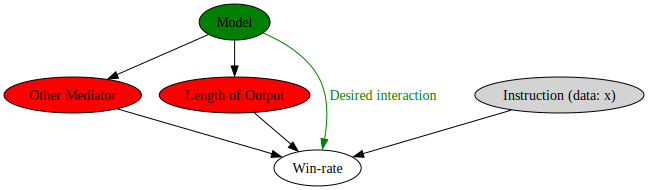

In [96]:
try:
    from graphviz import Digraph
    dot = Digraph()
    dot.node('M', 'Model', style='filled',fillcolor="green")
    dot.node('B', 'Other Mediator', style='filled', fillcolor="red",)
    dot.node('L', 'Length of Output', style='filled', fillcolor="red",)
    dot.node('I', 'Instruction (data: x)', style='filled', fillcolor="lightgray")
    dot.node('S', 'Win-rate')
    dot.edge('M', 'L')
    dot.edge('M', 'B')
    dot.edge('B', 'S')
    dot.edge('L', 'S')
    dot.edge('I', 'S')
    dot.edge('M', 'S', "  Desired interaction", color="green", fontcolor="green")
    dot.render('causal_graph', format='png', cleanup=True)
    display(dot)
except ImportError:
    from IPython.display import Image
    Image(filename="notebooks/causal_graph.png")

The benefit of taking such perspective is that:
1. it gives us a very general way of dealing with "biases"/mediators we do not want to consider (in our case, length, but this can be any mediator).
2. this is well studied, and a very common approach to dealing with simialr problems to ours (e.g. in social sciences, clinical studies, econometrics, ...)

So all we need is to write a reasonable (generalized) **linear structural equation** that conditions on:
- undesirable mediators (red above) => condition on covariate you don't want to consider. We will later set those to the same as the baseline model.
- on the treatment (green above) => measure the actual interaction you care about.
- on any other covariate that does not interact with mediators & the treatment. This simply improves our estimation.

A natural choice is the following:

$$win\_rate(m) = \frac{1}{N} \sum_{i=1}^{N} logistic(\mathbf{w}_l[m] * binned(length(x_i)) + \mathbf{w}_x^T \cdot C(x_i) + \mathbf{w}_m[m])$$

Where words that start with an upper case letter are (or return) vectors, $C()$ one hot-encodes, $\mathrm{W}_*$|$\mathbf{w}_*$|$w_*$ are respectively is a matrix|vector|scalar of trainable weights, $^T \cdot$ is dot product, $x$ is the instruction, $m$ is the model, and $binned$ bins into quantile.

Note:
- win-rate is the probability of beating the baseline => natural to predict with logistic fn
- everything is a pretty natural choice besides $binned$, which makes the assumption that the length quantile has a linear effect on the (logit of the) output. I actually tried making fewer assumption by using $\mathbf{w}_l[m]^T \cdot C(binned(length(x)))$ but it didn't work as well.
- very easy to add new mediators when we will want to control for those

- **What**: fit a logistic between instruction / length / model -> win_rate. This will be estimate to give the direct effect of the model on the win_rate, while conditioning away the effect of mediators. We could then use $\mathbf{w}_m[m]$ as a length-controlled metric, but given that we want the metric to still be interpreted on the same scale as the previous win rate, we will instead set the mediators to the values from the baseline (i.e. same length of output). This can then essentially be thought of as "what would be the win-rate if the model's outputs were the same length as the baseline ones" (actual causal conclusions would need more care).
- **Benefits**:
    - **(D1-D3) metrics**: much better in all metrics than raw win-rate, even better than the two previous ones.
    - standard: standard analysis for controlling covariates.
    - **(D5) ~interpretability**: similar interpretation as win-rate and same scale. It's still harder to interpret than raw/balanced win-rate, but simpler than length normalized.
    - **(D6) generality**: the procedure is extremely general, e.g., if we wanted to control for the amount of lists we could jsut throw that as a covariate. Furthermore, this is the ~likely the best things to do from a statistical point of view (assuming you don't have enough examples for propensity score matching) => giving the right example for other benchmarks.
    - **(D7) robustness**: compared to the two previous examples this method is robust for whatever lengths of enw models, given that the parameters&binning will be fitted on the new models independently of the the previous ones.
    - **(D8) ~independence**: the only parameters that need to be fitted across models is $\mathbf{w}_x^T$, which can be thought of as "the difficulty" of the current example. Given that we already have 120 examples for each of those parameters, we can fit them nwo and hold those constants for new models. Conditioned on those parameter, we will be able to control the lengths for new models independently of other models => no need to recompute the rankings.
- **Downside**:
    - ~interpretability: although regression analysis for conrolling covaraites is common in stats, it might nto be as natural for some of the NLP / LLM-enthousiast community
    - functional form: although pretty standard it's unclear whether the functional form (e.g. lienarity) really makes sense
    - **(D4) simplicity**: the procedure is more involved than for previous metrics, which will make it harder for people to understand and might decrease the use of it. 

Overall, I think this is the best option we have, but I do worry about the fact that it makes the metric harder to understand.

In [83]:

    
def make_data(all_df_annotations, instruction_difficulty=None, n_bins = 20):
    df = all_df_annotations.copy()
    df["delta_len"] = df["len_1"] - df["len_2"]
    df["rand_delta_len"] = df["delta_len"].astype(float) + ((np.random.rand(len(df))-0.5)*1e-3 )
    df[f"grouped_q{n_bins}_delta_len"] = df.groupby("generator_2")["rand_delta_len"].transform(lambda x: pd.qcut(x, n_bins, labels=False, duplicates="drop"))
    df["instruction_difficulty"] = df["index"].transform(lambda g: instruction_difficulty[g])

    rows_per_model = {}
    sub_df = instruction_difficulty.to_frame().reset_index(drop=False).copy()
    all_models = df["generator_2"].unique()
    ordered_models = ['gpt4_1106_preview'] + [m for m in all_models if m != "gpt4_1106_preview"]
    for m in ordered_models:
        rows_per_model[m] = sub_df.copy()
        rows_per_model[m]["generator_2"] = m
    df_lb = pd.concat(rows_per_model.values(), axis=0)
    group_qn_no_delta = df.groupby("generator_2").apply(lambda d: d[d["delta_len"].abs() == d["delta_len"].abs().min()][f"grouped_q{n_bins}_delta_len"].iloc[0], include_groups=False)
    df_lb[f"grouped_q{n_bins}_delta_len"] = df_lb["generator_2"].transform(lambda g: group_qn_no_delta[g])

    return df, df_lb


def logloss(y_true, y_pred):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

def logloss_sampleweight(y_true, y_pred, sample_weight):
    # y_true is binary and sample_weight says the proba for that class. Let's revert that transform
    y_true = np.where(y_true==1, sample_weight, 1-sample_weight)
    return logloss(y_true, y_pred)


def make_dmatrix_for_model(df, df_lb, formula="C(grouped_q10_delta_len) + instruction_difficulty ", col_y_true="preference"):
    df_inp = dmatrix(formula, df , return_type="dataframe")
    df_inp_lb = build_design_matrices([df_inp.design_info], df_lb, return_type='dataframe')[0]
    df_inp[col_y_true] = df[col_y_true]
    return df_inp, df_inp_lb
    
def fit_LogisticRegressionCV(data, col_y_true, is_ytrue_proba=True, n_splits=5, C=100, **kwargs):
    """Fits LogisticRegressionCV with optionally y_true being probabilities rather than the labels."""
    dflt_kwargs = dict(random_state=123, dual=False, penalty="l1", solver='liblinear', n_jobs=None, fit_intercept=False)
    dflt_kwargs.update(kwargs)
    if not is_ytrue_proba:
        if n_splits > 0:
            model = LogisticRegressionCV(cv=n_splits, **dflt_kwargs)
        else:
            model = LogisticRegression(C=C, **dflt_kwargs)
        model.fit(data.drop(columns=[col_y_true]), (data[col_y_true]).round().astype(int))
    else:
        # duplicate the df, once with label 0 and once with label 1
        data = data.reset_index(drop=True).reset_index(drop=False, names=["group"])
        data_1 = data.copy()
        data_1["y"] = 1
        data_0 = data.copy()
        data_0[col_y_true] = 1 - data_0[col_y_true]
        data_0["y"] = 0
        data_dup = pd.concat([data_1, data_0], axis=0).reset_index(drop=True)
        if n_splits > 0:
            cv = GroupKFold(n_splits=n_splits) 
            scorer = make_scorer(logloss_sampleweight, response_method="predict_proba", greater_is_better=False).set_score_request(sample_weight=True)
            model = LogisticRegressionCV(cv=cv, scoring=scorer, **dflt_kwargs)
            fit_kwargs = dict(groups=data_dup["group"])
        else:
            model = LogisticRegression(C=C, **dflt_kwargs)
            fit_kwargs = dict()
            
        model.set_fit_request(sample_weight=True)
        model.fit(X=data_dup.drop(columns=[col_y_true, "y", "group"]), 
                  y=data_dup["y"], 
                  sample_weight=data_dup[col_y_true], **fit_kwargs)
    return model

def disjoint_optimization_(df, df_lb, formula):
    all_reports = dict()
    curr_df_lb = df_lb.copy()
    for m in df["generator_2"].unique():
        # this is what will actually have to run for each new model
        df_input, df_input_lb = make_dmatrix_for_model(df.query(f"generator_2 == '{m}'"), 
                                                       curr_df_lb.query(f"generator_2 == '{m}'"), 
                                                       formula=formula)
        model = fit_LogisticRegressionCV(df_input, "preference", is_ytrue_proba=True, n_splits=5)
        curr_df_lb.loc[curr_df_lb["generator_2"] == m, "preference"] = model.predict_proba(df_input_lb)[:,1]
    lb[formula] = curr_df_lb.groupby("generator_2")["preference"].mean()[lb.index] * 100

First, let's load the instruction complexity ($\mathbf{w}_x^T$) which I precomputed by joint fitting across all the models.

In [84]:
from huggingface_hub import hf_hub_download
out = hf_hub_download(repo_id="tatsu-lab/alpaca_eval", 
                filename="instruction_difficulty.csv",
                repo_type="dataset",
                cache_dir=constants.DEFAULT_CACHE_DIR)
               
instruction_difficulty = pd.read_csv(out, index_col=0).squeeze()

In [87]:
%%time

formula=f"grouped_q20_delta_len + instruction_difficulty"

# df_lb contains the covariate that are held the same as the baseline 
df, df_lb = make_data(all_df_annotations, instruction_difficulty=instruction_difficulty)

# run the disjoint optimization for all models.
disjoint_optimization_(df, df_lb, formula=formula)

CPU times: user 9.5 s, sys: 82.7 ms, total: 9.59 s
Wall time: 9.64 s


In [156]:
report(lb, formula)

# Report for **grouped_q20_delta_len + instruction_difficulty**

## Gameability (lower is better)
Verbosity gameability (relative std metric): 9.6%
Conciseness gameability (relative std metric): 14.5%

## Correlation with Arena (higher is better)
Spearman Corr: 0.967
Kendall Corr: 0.849

## Correlation with length (closer to spearman=0.24, kendall=0.16 is better)
Spearman Corr: 0.218
Kendall Corr: 0.135

## Top 10 models


gpt4_1106_preview                        50.000000
gpt4_1106_preview_verbose                48.410368
gpt4_1106_preview_concise                41.483510
Qwen1.5-72B-Chat                         40.423848
gpt4                                     38.343078
gpt4_0613_verbose                        35.900803
gpt4_0314                                35.571320
claude-2.1_verbose                       33.344125
mistral-medium                           31.149406
Snorkel-Mistral-PairRM-DPO-best-of-16    30.419699
Name: grouped_q20_delta_len + instruction_difficulty, dtype: float64


## Bottom 10 models


chatglm2-6b               5.898332
alpaca-7b_concise         5.754277
llama-2-7b-chat-hf        5.711359
openbuddy-falcon-7b-v6    5.598822
oasst-sft-pythia-12b      5.394793
baize-v2-7b               4.713379
pythia-12b-mix-sft        4.275406
guanaco-13b               3.702956
guanaco-7b                3.520180
baichuan-13b-chat         2.851103
Name: grouped_q20_delta_len + instruction_difficulty, dtype: float64

We see that:
- gameability is low (lower than the two other metrics)
- length correlation is similar to Arena (similar to length normalized)
- human correlation is extremely high (even higher than length normalized)

In [155]:
show_new_lb(lb, "grouped_q20_delta_len + instruction_difficulty")

,win_rate,new_win_rate,delta_win_rate,rank_win_rate,rank_new_win_rate,delta_rank
gpt4_1106_preview_verbose,64.303601,48.410368,-15.893234,0,1,-1
gpt4_1106_preview,50.000000,50.000000,0.000000,1,0,1
Snorkel-Mistral-PairRM-DPO-best-of-16,34.860133,30.419699,-4.440433,2,9,-7
pairrm-Yi-34B-Chat,31.241283,28.871299,-2.369984,3,13,-10
Snorkel-Mistral-PairRM-DPO,30.220053,27.529751,-2.690302,4,16,-12
Yi-34B-Chat,29.659947,26.488479,-3.171467,5,18,-13
Qwen1.5-72B-Chat,26.498283,40.423848,13.925565,6,3,3
Mixtral-8x7B-Instruct-v0.1_verbose,24.614063,22.916449,-1.697614,7,27,-20
claude-2.1_verbose,24.354071,33.344125,8.990054,8,7,1
gpt4,23.576789,38.343078,14.766289,9,4,5
